# Demo: Exploring clinical data from multiple commons
Fan Wang

July 15 2020

### Data Source:
| Project              | Data description                                         | Subjects | Source                 |
| :------------------: | :------------------------------------------------------: | :------: | :----------------------------------: |
| open-DS4C (Kaggle) | Epidemiology individual-level line lists in South Korea | 3519 | Korea CDC and local governments|
| open-DSCI (Kaggle) | Epidemiology individual-level line lists in Indonesia | 893 | Regional government website and public communities in Indonesia|
| open-DSFSI (Kaggle) | Epidemiology individual-level line lists in Africa | 10087 | Africa CDC and Ministries of Health|
| open-nCoV2019 (UW) | Epidemiology individual-level line lists around the world | 1083 | University of Washington Institute for Health Metrics and Evaluation|
| TCGA-OV (GDC) | Clinical data for TCGA ovarian cancer samples | 608 | NCI Genomic Data Commons (GDC) |

In this notebook, we obtain the clinical data for multiple projects from Chicagoland Pandemic Response Commons and NCI Genomic Data Commons (GDC) and visualize some of the clinical attributes. This notebook is for demonstration purposes only and not biologically meaningful.

### Import libraries

In [4]:
%%capture
! https_proxy=http://cloud-proxy.internal.io:3128 pip install joypy
! pip install --proxy=http://cloud-proxy.internal.io:3128 --user gen3        
# main libraries
import requests, json, fnmatch, os, os.path, sys, subprocess, glob, ntpath, copy, gen3
from gen3.auth import Gen3Auth
from gen3.submission import Gen3Submission
import pandas as pd
from functools import reduce
# visual libraries
import upsetplot
from upsetplot import UpSet
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
import joypy
import numpy as np
# notebook setting
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Use GDC API to extract clinical data for TCGA-OV

In [2]:
def get_gdc_clinical(project: str):
    gdc_url = "https://api.gdc.cancer.gov/cases"
    headers = {"Content-Type": "application/json"}
    fields = "case_id,submitter_id,project.project_id,project.name"
    expand = "diagnoses,demographic,family_histories"
    params = {
        "filters": {
            "op": "in",
            "content": {"field": "project.project_id", "value": [project]},
        },
        "format": "TSV",
        "size": "10000",
        "fields": fields,
        "expand": expand,
    }
    response = requests.post(
        gdc_url, data=json.dumps(params), headers=headers, stream=True
    )
    return response.content


# TCGA-OV
project = "TCGA-OV"
ofil = "{0}.clinical.tsv".format(project)
with open(ofil, "wt") as o:
    o.write(get_gdc_clinical(project).decode("utf-8"))

gdc_df = pd.read_csv(ofil, sep="\t")

### Visualize `Age at Diagnosis` and `Year to Death` in TCGA-OV

<Figure size 1600x1200 with 0 Axes>

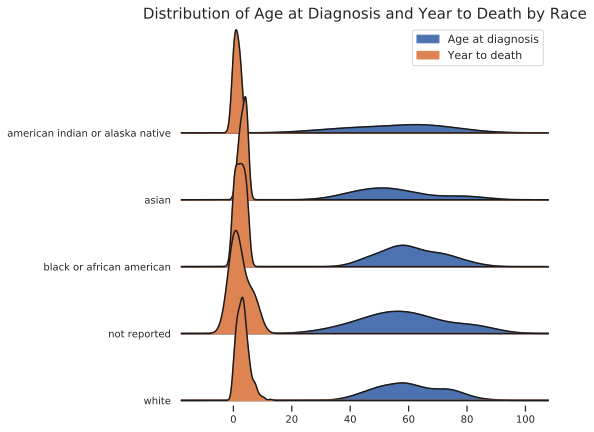

In [5]:
df = gdc_df[
    ["demographic.race", "diagnoses.0.age_at_diagnosis", "demographic.days_to_death"]
]
df["Age at diagnosis"] = df["diagnoses.0.age_at_diagnosis"] / 365
df["Year to death"] = df["demographic.days_to_death"] / 365
df["Race"] = df["demographic.race"]
df = df.dropna(subset=["Age at diagnosis"])
plt.figure(figsize=(8, 6), dpi=200)
fig, axes = joypy.joyplot(
    df.loc[df.Race != "native hawaiian or other pacific islander"],
    column=["Age at diagnosis", "Year to death"],
    by="Race",
    ylim="own",
    figsize=(8, 6),
    overlap=1,
    legend=True,
)
plt.title("Distribution of Age at Diagnosis and Year to Death by Race", fontsize=15)
plt.show()

### Visualize `Tumor Stage` and `Vital Status` in TCGA-OV

<Figure size 2000x1600 with 0 Axes>

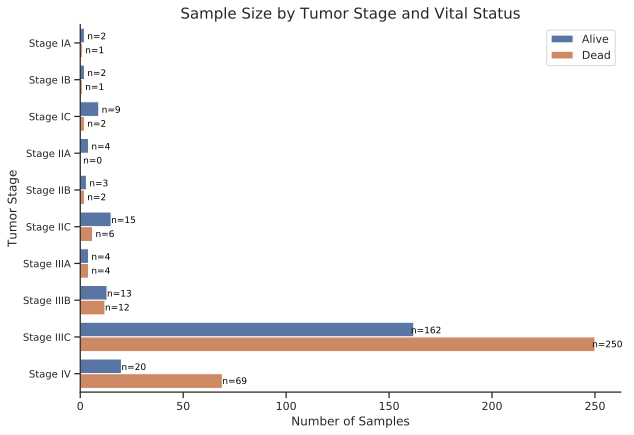

In [6]:
plt.figure(figsize=(10, 8), dpi=200)
vital_figo_df = (
    gdc_df.loc[:, ["case_id", "demographic.vital_status", "diagnoses.0.figo_stage"]]
    .groupby(["demographic.vital_status", "diagnoses.0.figo_stage"])
    .size()
    .reset_index(name="counts")
)
vital_figo_df = vital_figo_df.loc[
    vital_figo_df["demographic.vital_status"] != "Not Reported"
]
table = pd.pivot_table(
    vital_figo_df,
    columns=["demographic.vital_status"],
    values=["counts"],
    index="diagnoses.0.figo_stage",
    aggfunc=np.sum,
    fill_value=0,
)
table["index"] = range(10)
g = sns.catplot(
    x="counts",
    y="diagnoses.0.figo_stage",
    data=vital_figo_df,
    hue="demographic.vital_status",
    kind="bar",
    height=6,
    aspect=1.5,
    legend=False,
)
for row in table.itertuples():
    g.ax.text(
        row[1] + 6,
        row[3] - 0.1,
        "n=" + str(row[1]),
        horizontalalignment="center",
        size=9,
        color="black",
    )
for row in table.itertuples():
    g.ax.text(
        row[2] + 6,
        row[3] + 0.28,
        "n=" + str(row[2]),
        horizontalalignment="center",
        size=9,
        color="black",
    )
plt.xlabel("Number of Samples")
plt.ylabel("Tumor Stage")
plt.yticks(fontsize=10)
plt.title("Sample Size by Tumor Stage and Vital Status", fontsize=15)
plt.legend()
plt.show()

### Use Gen3 SDK to extract clinical data for COVID-19 datasets
To extract the data we need, we simply export the `subject` node from the Chicagoland Pandemic Response Commons.

In [7]:
api = "https://chicagoland.pandemicresponsecommons.org/"
creds = "./credentials_covid.json"
auth = Gen3Auth(api, refresh_file=creds)
sub = Gen3Submission(api, auth)

def get_node_tsvs(node, projects=None, overwrite=False):
    # Get a TSV of the node(s) specified for each project specified
    if not isinstance(node, str):  # Create folder on VM for downloaded files
        mydir = "downloaded_tsvs"
    else:
        mydir = str(node + "_tsvs")
    if not os.path.exists(mydir):
        os.makedirs(mydir)
    if projects is None:  # if no projects specified, get node for all projects
        project_ids = list(
            json_normalize(
                sub.query("""{project (first:0){project_id}}""")["data"]["project"]
            )["project_id"]
        )
    elif isinstance(projects, str):
        projects = [projects]
    dfs = []
    df_len = 0
    for project in projects:
        filename = str(mydir + "/" + project + "_" + node + ".tsv")
        if (os.path.isfile(filename)) and (overwrite is False):
            print("File previously downloaded.")
        else:
            prog, proj = project.split("-", 1)
            sub.export_node(prog, proj, node, "tsv", filename)
        df1 = pd.read_csv(filename, sep="\t", header=0)
        dfs.append(df1)
        df_len += len(df1)
        print(filename + " has " + str(len(df1)) + " records.")
    all_data = pd.concat(dfs, ignore_index=True)
    print("length of all dfs: " + str(df_len))
    nodefile = str("master_" + node + ".tsv")
    all_data.to_csv(str(mydir + "/" + nodefile), sep="\t")
    print(
        "Master node TSV with "
        + str(len(all_data))
        + " total records written to "
        + nodefile
        + "."
    )
    return all_data

# Get subject node tsvs
DS4C = get_node_tsvs("subject", "open-DS4C")
DSCI = get_node_tsvs("subject", "open-DSCI")
DSFSI = get_node_tsvs("subject", "open-DSFSI")
nCOV2019 = get_node_tsvs("subject", "open-nCoV2019")

File previously downloaded.
subject_tsvs/open-DS4C_subject.tsv has 5164 records.
length of all dfs: 5164
Master node TSV with 5164 total records written to master_subject.tsv.
File previously downloaded.
subject_tsvs/open-DSCI_subject.tsv has 893 records.
length of all dfs: 893
Master node TSV with 893 total records written to master_subject.tsv.
File previously downloaded.
subject_tsvs/open-DSFSI_subject.tsv has 10087 records.
length of all dfs: 10087
Master node TSV with 10087 total records written to master_subject.tsv.
File previously downloaded.
subject_tsvs/open-nCoV2019_subject.tsv has 1083 records.
length of all dfs: 1083
Master node TSV with 1083 total records written to master_subject.tsv.


### Harmonize symptoms across COVID-19 datasets

In [8]:
dsfsi = DSFSI[["age", "symptoms"]].dropna(subset=["symptoms"])
ncov2019 = nCOV2019[["age", "symptoms"]].dropna(subset=["symptoms"])

In [9]:
def harmonize_symptoms(dataframe):
    dataframe["symptom"] = dataframe["symptoms"].str.split(",")
    for symptom in set.union(*dataframe.symptom.apply(set)):
        dataframe[symptom] = dataframe.apply(
            lambda _: int(symptom in _.symptom), axis=1
        )
    dataframe = dataframe.drop(["symptoms", "symptom"], axis=1)
    symptoms = dataframe.columns.tolist()
    symptoms.remove("age")
    for symptom in symptoms:
        dataframe = dataframe.replace({symptom: {0: False, 1: True}})
    return dataframe

### Visualize the combinations of symptoms in nCoV2019 dataset

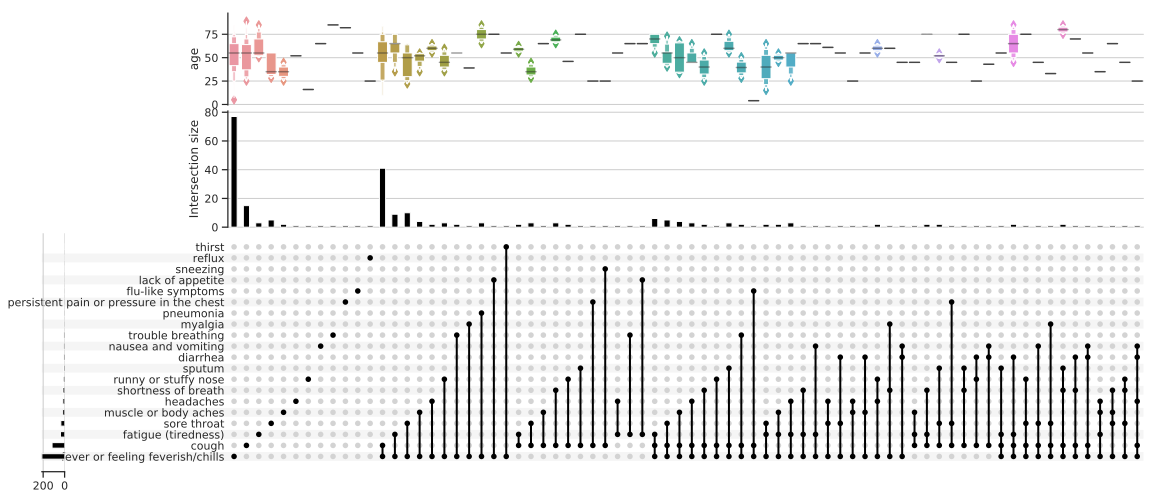

In [10]:
ncov2019_symptom = harmonize_symptoms(ncov2019)
symptoms = ncov2019_symptom.columns.tolist()
symptoms.remove("age")
ncov2019_symptom = ncov2019_symptom.set_index(symptoms)
upset = UpSet(
    ncov2019_symptom, subset_size="count", intersection_plot_elements=10, element_size=16
)
upset.add_catplot(value="age", kind="boxen", elements=8)
upset.plot()
plt.show()

### Visualize the combinations of symptoms in DSFSI dataset

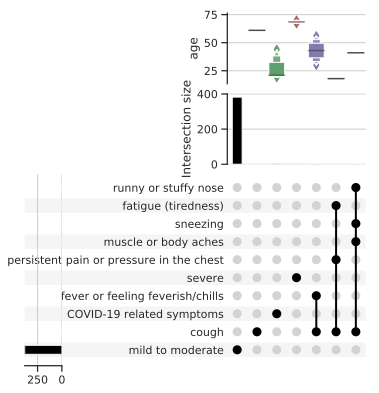

In [11]:
dsfsi_symptom = harmonize_symptoms(dsfsi.loc[dsfsi.symptoms != "no data"])
dsfsi_symptom = dsfsi_symptom.drop(["fever* or feeling feverish/chills"], axis=1)
symptoms = dsfsi_symptom.columns.tolist()
symptoms.remove("age")
dsfsi_symptom = dsfsi_symptom.set_index(symptoms)
upset = UpSet(
    dsfsi_symptom, subset_size="count", intersection_plot_elements=4, element_size=26
)
upset.add_catplot(value="age", kind="boxen", elements=4)
upset.plot()
plt.show()

### Visualize case fatality rates by age in four COVID-19 datasets and TCGA-OV

In [12]:
gdc_fatality = gdc_df[
    ["diagnoses.0.age_at_diagnosis", "demographic.vital_status"]
].dropna(subset=["diagnoses.0.age_at_diagnosis"])
gdc_fatality["age"] = gdc_fatality["diagnoses.0.age_at_diagnosis"] / 365


def define_age_decade(dataset):
    dataset.loc[(dataset["age"] < 10), "age_decade"] = "0s"
    dataset.loc[(dataset["age"] < 20) & (dataset["age"] >= 10), "age_decade"] = "10s"
    dataset.loc[(dataset["age"] < 30) & (dataset["age"] >= 20), "age_decade"] = "20s"
    dataset.loc[(dataset["age"] < 40) & (dataset["age"] >= 30), "age_decade"] = "30s"
    dataset.loc[(dataset["age"] < 50) & (dataset["age"] >= 40), "age_decade"] = "40s"
    dataset.loc[(dataset["age"] < 60) & (dataset["age"] >= 50), "age_decade"] = "50s"
    dataset.loc[(dataset["age"] < 70) & (dataset["age"] >= 60), "age_decade"] = "60s"
    dataset.loc[(dataset["age"] < 80) & (dataset["age"] >= 70), "age_decade"] = "70s"
    dataset.loc[(dataset["age"] < 90) & (dataset["age"] >= 80), "age_decade"] = "80s"
    dataset.loc[(dataset["age"] < 100) & (dataset["age"] >= 90), "age_decade"] = "90s"
    dataset.loc[(dataset["age"] >= 100), "age_decade"] = "100s"
    return dataset[dataset.age_decade.notna()]

Calculate fatality rates

The fatality rate is the number of confirmed deaths divided by the number of confirmed cases.

In [16]:
# Calculate fatality rate for TCGA-OV
gdc_fatality = define_age_decade(gdc_fatality[["age", "demographic.vital_status"]])
gdc_fatality_percent = (
    gdc_fatality.loc[gdc_fatality["demographic.vital_status"] == "Dead"]
    .groupby(["age_decade"])
    .count()
    / gdc_fatality.shape[0]
)
gdc_fatality_percent = gdc_fatality_percent.rename(
    columns={"age": "fatality_rate"}
)
gdc_fatality_percent = gdc_fatality_percent.drop(["demographic.vital_status"], axis=1)
gdc_fatality_percent["dataset"] = "TCGA: Ovarian Cancer (GDC)"
# Calculate fatality rate for DSFSI
dsfsi_fatality = define_age_decade(DSFSI[["age", "current_state"]])
dsfsi_fatality_percent = (
    dsfsi_fatality.loc[dsfsi_fatality["current_state"] == "deceased"]
    .groupby(["age_decade"])
    .count()
    / dsfsi_fatality.shape[0]
)
dsfsi_fatality_percent = dsfsi_fatality_percent.rename(columns={"age": "fatality_rate"})
dsfsi_fatality_percent = dsfsi_fatality_percent.drop(["current_state"], axis=1)
dsfsi_fatality_percent["dataset"] = "Africa"
# Calculate fatality rate for DSCI
dsci_fatality = define_age_decade(DSCI[["age", "current_state"]])
dsci_fatality_percent = (
    dsci_fatality.loc[dsci_fatality["current_state"] == "deceased"]
    .groupby(["age_decade"])
    .count()
    / dsci_fatality.shape[0]
)
dsci_fatality_percent = dsci_fatality_percent.rename(columns={"age": "fatality_rate"})
dsci_fatality_percent = dsci_fatality_percent.drop(["current_state"], axis=1)
dsci_fatality_percent["dataset"] = "Indonesia"
# Calculate fatality rate for nCoV2019
ncov2019_fatality = define_age_decade(nCOV2019[["age", "death"]])
ncov2019_fatality_percent = (
    ncov2019_fatality.loc[ncov2019_fatality["death"] == True]
    .groupby(["age_decade"])
    .count()
    / ncov2019_fatality.shape[0]
)
ncov2019_fatality_percent = ncov2019_fatality_percent.rename(
    columns={"death": "fatality_rate"}
)
ncov2019_fatality_percent = ncov2019_fatality_percent.drop(["age"], axis=1)
ncov2019_fatality_percent["dataset"] = "nCOV2019"
# Calculate fatality rate for DS4C
ds4c_fatality = DS4C[["age_decade", "current_state"]]
ds4c_fatality_percent = (
    ds4c_fatality.loc[ds4c_fatality["current_state"] == "deceased"].groupby(["age_decade"]).count()
    / ds4c_fatality.shape[0]
)
ds4c_fatality_percent = ds4c_fatality_percent.rename(columns={"current_state": "fatality_rate"})
ds4c_fatality_percent["dataset"] = "South Korea"

Text(0.5,1,'Fatality Rates by Age in COVID-19 and TCGA Ovarian Cancer')

<Figure size 2000x1600 with 0 Axes>

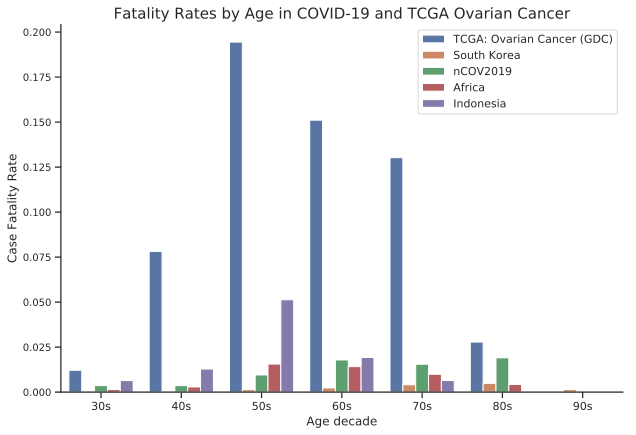

In [20]:
data_frames = [
    dsci_fatality_percent,
    dsfsi_fatality_percent,
    ncov2019_fatality_percent,
    ds4c_fatality_percent,
    gdc_fatality_percent
]

plt.figure(figsize=(10, 8), dpi=200)

fatality_all = reduce(
    lambda left, right: right.append(left, sort=False),
    data_frames,
)

fatality_all["age_decade"] = fatality_all.index
g = sns.catplot(
    x="age_decade",
    y="fatality_rate",
    data=fatality_all,
    hue="dataset",
    kind="bar",
    height=6,
    aspect=1.5,
    legend=False,
)
plt.legend(loc='upper right')
plt.xlabel("Age decade")
plt.ylabel("Case Fatality Rate")
plt.yticks(fontsize=10)
plt.title("Fatality Rates by Age in COVID-19 and TCGA Ovarian Cancer", fontsize=15)